In [17]:
import tensorflow as tf
import numpy as np
import os
import re
import io
import librosa
import pickle
import random
import matplotlib.pyplot as plt
import IPython.display as ipd
from os.path import isdir, join
%matplotlib inline

In [18]:
save_dir = "/home/maikfangogoair/tmp/save/"
pkl_file = "spect_v7.pkl"
with open (save_dir + pkl_file, 'rb') as fp:
    all_data = pickle.load(fp)
print("There are total %d data to be trained." % len(all_data))

There are total 71305 data to be trained.


In [6]:
tf.reset_default_graph();
input=tf.placeholder(tf.float32, (None, 99, 161), 'input')
def spectrogram_ConvNet(input):
    """
    """
    dropout_prob = tf.placeholder(tf.float32, name='dropout_prob')
    
    
    reshape_input = tf.reshape(input, [-1, 99, 161, 1], 'reshape_input')
    batch_input = tf.layers.batch_normalization(reshape_input)
    
    conv_1 = tf.layers.conv2d(batch_input, 64, (5,5), (1,1), 'same', name='conv_1')
    relu_1 = tf.nn.relu(conv_1,'relu_1')
    dropout_1 = tf.nn.dropout(relu_1, dropout_prob, name = 'dropout_1')
    
    max_pool = tf.nn.max_pool(dropout_1, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')

    conv_2 = tf.layers.conv2d(max_pool, 64, (3,3), (1,1), 'same')
    relu_2 = tf.nn.relu(conv_2,'relu_2')
    dropout_2 = tf.nn.dropout(relu_2, dropout_prob, name = 'dropout_2')
    
    size=int(dropout_2.get_shape()[1]) * int(dropout_2.get_shape()[2]) * int(dropout_2.get_shape()[3])
    flatten = tf.reshape(dropout_2, (-1, size), 'flatten')

    logits = tf.layers.dense(flatten, 12,name = 'logits')
    
    return logits,dropout_prob

In [25]:
tf.reset_default_graph();
input=tf.placeholder(tf.float32, (None, 1, 161, 101))
              
def VGG11(input, final_class, verbose):
    steps = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
    dropout_prob = tf.placeholder(tf.float32, name='dropout_prob')
    features = tf.transpose(input,[0, 2, 3, 1])
    if verbose: print(features)
    for i in range(len(steps)):
        step = steps[i]
        with tf.variable_scope("Layer"+str(i+1), reuse=False):
            if step == 'M':
                features = tf.layers.max_pooling2d(features , (2,2) , (2,2) ,"same")
                if verbose: print(features)
            else:
                features = tf.layers.conv2d(features, step, (3,3), (1,1), 'same', name='conv_1')
                if verbose: print(features)
                features = tf.layers.batch_normalization(features)
                if verbose: print(features)
                features = tf.nn.relu(features)
                if verbose: print(features)
    features = tf.layers.average_pooling2d(features , (1,1), (1,1), 'same')
    if verbose: print(features)
    features = tf.layers.flatten(features)
    if verbose: print(features)
    features = tf.layers.dense(features, 512)
    if verbose: print(features)
    logits = tf.layers.dense(features, final_class )
    if verbose: print(features)
    
    return logits,dropout_prob

In [26]:
model_name = "VGG11"
model_cfg = {"spectrogram_ConvNet": spectrogram_ConvNet, "VGG11": VGG11}
model = model_cfg[model_name]
with io.open(save_dir + "wanted_list.pkl", 'rb') as f:
    wanted_list = pickle.load(f)
print(wanted_list)
final_class = len(wanted_list)
print("class count is : %d ." % final_class)
logits,dropout_prob = model(input, final_class, False)

['four', 'tree', 'left', 'right', 'down', 'stop', 'nine', 'cat', 'no', 'three', 'bird', 'one', 'zero', 'house', 'eight', 'six', 'off', 'two', 'yes', 'seven', 'happy', 'marvin', 'up', 'bed', 'on', 'dog', 'go', 'five', 'sheila', 'wow', 'silence']
class count is : 31 .


In [27]:
#training steps
ground_truth_input = tf.placeholder(tf.int64, [None], name='groundtruth_input')
learning_rate_input = tf.placeholder(tf.float32, [], name='learning_rate_input')
cross_entropy_mean = tf.losses.sparse_softmax_cross_entropy(ground_truth_input, logits)
#train_step = tf.train.GradientDescentOptimizer(learning_rate_input).minimize(cross_entropy_mean)
train_step = tf.train.AdamOptimizer(learning_rate_input).minimize(cross_entropy_mean)

predicted_indices = tf.argmax(logits, 1)
correct_prediction = tf.equal(predicted_indices, ground_truth_input)
confusion_matrix = tf.confusion_matrix(ground_truth_input, predicted_indices, num_classes=12)
evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [30]:
random.seed(1222)
size=len([x for x in all_data if x["group"] == "training" ])
saver = tf.train.Saver(tf.global_variables())
init = tf.global_variables_initializer()

batch_size = 100
learning_rate = 1e-4
learning_decay = 0.9
learning_decay_period = 1000
eval_every_steps = 50
training_steps = 1000
print_every = 10
eval_size = 300
save_every_steps = 200
validation_size = len([x["label_idx"] for x in all_data if x["group"] == "validation"])
print("validation set count:" + str(validation_size))

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, save_dir + 'VGG11.ckpt-1000')
    for i in range(1, training_steps+1):
        start_pos = (i-1) * batch_size % size
        end_pos = (i-1) * batch_size % size + batch_size 
        train_fingerprints = np.asarray([x["feature"] for x in all_data if x["group"] == "training"][start_pos:end_pos])
        train_ground_truth = np.asarray([x["label_idx"] for x in all_data if x["group"] == "training"][start_pos:end_pos]) 
        loss, _ ,accurancy,  = sess.run([cross_entropy_mean, train_step, evaluation_step], \
                feed_dict={
                    input: train_fingerprints,
                    ground_truth_input: train_ground_truth,
                    learning_rate_input: learning_rate * (learning_decay**(i // learning_decay_period)),
                    dropout_prob: 0.5
                })
        if i % print_every == 0:
            print("Step %d, loss: %f, accurancy: %f." % (i, loss, accurancy))
        if  i % save_every_steps == 0:
            saver.save(sess, save_dir + model_name +".ckpt", global_step=i)
        if  i % eval_every_steps == 0:
            rand_choice = [random.randint(0,validation_size-1) for x in range(eval_size)]
            _, accurancy = sess.run([train_step,evaluation_step], \
                feed_dict={
                    input: np.asarray([x["feature"] for x in all_data if x["group"] == "validation"])[rand_choice],
                    ground_truth_input: np.asarray([x["label_idx"] for x in all_data if x["group"] == "validation"])[rand_choice], \
                    learning_rate_input: learning_rate * (learning_decay**(i // learning_decay_period)),
                    dropout_prob: 1.0
                })
            print("Validation accurancy is %f" % accurancy)

validation set count:7508
INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-1000


INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-1000


Step 10, loss: 0.108486, accurancy: 0.960000.
Step 20, loss: 0.239846, accurancy: 0.920000.
Step 30, loss: 0.242034, accurancy: 0.910000.
Step 40, loss: 0.160086, accurancy: 0.950000.
Step 50, loss: 0.188201, accurancy: 0.950000.
Validation accurancy is 0.893333
Step 60, loss: 0.066593, accurancy: 0.970000.
Step 70, loss: 0.087195, accurancy: 0.970000.
Step 80, loss: 0.276110, accurancy: 0.920000.
Step 90, loss: 0.135032, accurancy: 0.940000.
Step 100, loss: 0.166735, accurancy: 0.960000.
Validation accurancy is 0.930000
Step 110, loss: 0.039057, accurancy: 0.990000.
Step 120, loss: 0.184177, accurancy: 0.950000.
Step 130, loss: 0.185152, accurancy: 0.950000.
Step 140, loss: 0.153784, accurancy: 0.940000.
Step 150, loss: 0.167527, accurancy: 0.950000.
Validation accurancy is 0.953333
Step 160, loss: 0.080121, accurancy: 0.970000.
Step 170, loss: 0.065180, accurancy: 0.980000.
Step 180, loss: 0.339254, accurancy: 0.960000.
Step 190, loss: 0.043580, accurancy: 0.990000.
Step 200, loss: 0

In [31]:
train_audio_path = '/home/maikfangogoair/tmp/label_data/'
#testing
step_num = 10
test_set = [x for x in all_data if x["group"] == "testing"]
test_size = len(test_set) 
print("Testing set size is "+ str(test_size))
step_size = test_size // (step_num-1)
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, save_dir + 'VGG11.ckpt-1000')
    for i in range(step_num):
        start = i*step_size 
        end = min((i+1)*step_size , test_size)
        print("Testing from %d(include) to %d(exclude)..." % (start, end))
        predicted_list = sess.run(predicted_indices, \
            feed_dict={
                input: np.asarray([x["feature"] for x in test_set][start : end] ) ,
                dropout_prob: 1.0
            })
        if i == 0 :
            final_predicted_list = np.copy(predicted_list) 
        else:
            final_predicted_list = np.hstack((final_predicted_list, predicted_list))
print("Testing predicted list size is "+ str(len(final_predicted_list)))
wrong_list = []
for i in range(test_size):
    predicted_label_idx = final_predicted_list[i]
    if  predicted_label_idx != test_set[i]["label_idx"]:
        test_set[i]["predicted_label_idx"] = predicted_label_idx
        test_set[i]["predicted_label"] = wanted_list[predicted_label_idx]
        wrong_list.append(test_set[i])
print("There are %d wrong predictions in total %d data. Predictions accurancy is: %f" % \
      (len(wrong_list), test_size, (test_size - len(wrong_list)) / test_size))

Testing set size is 7559
INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-1000


INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-1000


Testing from 0(include) to 839(exclude)...
Testing from 839(include) to 1678(exclude)...
Testing from 1678(include) to 2517(exclude)...
Testing from 2517(include) to 3356(exclude)...
Testing from 3356(include) to 4195(exclude)...
Testing from 4195(include) to 5034(exclude)...
Testing from 5034(include) to 5873(exclude)...
Testing from 5873(include) to 6712(exclude)...
Testing from 6712(include) to 7551(exclude)...
Testing from 7551(include) to 7559(exclude)...
Testing predicted list size is 7559
There are 460 wrong predictions in total 7559 data. Predictions accurancy is: 0.939145


In [33]:
def confuse_map(wrong_list):
    confuse_map = {}
    for x in wrong_list:
        key = x["label"] + " is confused by " + x["predicted_label"]
        cnt = confuse_map.get(key, 0)
        confuse_map[key] = cnt + 1 
    #https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    import operator
    sorted_confuse_map = sorted(confuse_map.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_confuse_map

confuse_map(wrong_list)

[('three is confused by tree', 28),
 ('tree is confused by three', 19),
 ('no is confused by go', 11),
 ('go is confused by dog', 10),
 ('right is confused by five', 10),
 ('go is confused by no', 8),
 ('down is confused by go', 7),
 ('no is confused by down', 7),
 ('left is confused by yes', 6),
 ('five is confused by right', 6),
 ('one is confused by nine', 6),
 ('two is confused by go', 5),
 ('five is confused by on', 5),
 ('up is confused by off', 5),
 ('six is confused by three', 5),
 ('down is confused by no', 4),
 ('three is confused by seven', 4),
 ('left is confused by bed', 4),
 ('happy is confused by cat', 4),
 ('zero is confused by sheila', 4),
 ('eight is confused by three', 4),
 ('go is confused by two', 4),
 ('dog is confused by down', 4),
 ('tree is confused by two', 4),
 ('right is confused by bed', 4),
 ('two is confused by zero', 4),
 ('bed is confused by bird', 3),
 ('bed is confused by left', 3),
 ('right is confused by left', 3),
 ('yes is confused by six', 3),
 (

In [34]:
def get_spect(path, window_size=.02, window_stride=.01, window='hamming', normalize = True, max_len=101):
    y, sr = librosa.load(path, sr=None)
    n_fft = int(sr * window_size)
    win_length = n_fft
    hop_length = int(sr * window_stride)

    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    spect, _ = librosa.magphase(D)
    # S = log(S+1)
    spect = np.log1p(spect)

    # make all spects with the same dims
    # TODO: change that in the future
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:max_len, ]
    spect = np.resize(spect, (1, spect.shape[0], spect.shape[1]))
    if normalize:
        mean = spect.mean()
        std = spect.std()
        if std != 0:
            spect = (spect - mean) /std

    return spect

In [35]:
test_audio_path = '/home/maikfangogoair/test/audio/'
files = [x for x in os.listdir(test_audio_path) if x.endswith('.wav') or x.endswith('.WAV')]
test_size = len(files)
batch_size = 300
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, save_dir + 'VGG11.ckpt-1000')
    for  i in range(0, len(files), batch_size):
        end = min(i + batch_size, test_size)
        print("Testing from %d(include) to %d(exclude)..." % (i, end))
        batch_data = []
        for j in range(i, end):
            spect = get_spect(test_audio_path + files[j])
            batch_data.append({"filename":files[j], "feature":spect})
            
        predicted_list = sess.run(predicted_indices, \
                feed_dict={
                    input: np.asarray([x["feature"] for x in batch_data] ) ,
                    dropout_prob: 1.0
                })
        
        if i == 0 :
            final_predicted_list = np.copy(predicted_list) 
            wild_test_data = batch_data
        else:
            final_predicted_list = np.hstack((final_predicted_list, predicted_list))
            wild_test_data += batch_data

INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-1000


INFO:tensorflow:Restoring parameters from /home/maikfangogoair/tmp/save/VGG11.ckpt-1000


Testing from 0(include) to 300(exclude)...
Testing from 300(include) to 600(exclude)...
Testing from 600(include) to 900(exclude)...
Testing from 900(include) to 1200(exclude)...
Testing from 1200(include) to 1500(exclude)...
Testing from 1500(include) to 1800(exclude)...
Testing from 1800(include) to 2100(exclude)...
Testing from 2100(include) to 2400(exclude)...
Testing from 2400(include) to 2700(exclude)...
Testing from 2700(include) to 3000(exclude)...
Testing from 3000(include) to 3300(exclude)...
Testing from 3300(include) to 3600(exclude)...
Testing from 3600(include) to 3900(exclude)...
Testing from 3900(include) to 4200(exclude)...
Testing from 4200(include) to 4500(exclude)...
Testing from 4500(include) to 4800(exclude)...
Testing from 4800(include) to 5100(exclude)...
Testing from 5100(include) to 5400(exclude)...
Testing from 5400(include) to 5700(exclude)...
Testing from 5700(include) to 6000(exclude)...
Testing from 6000(include) to 6300(exclude)...
Testing from 6300(incl

In [36]:
competition_list = ['silence', 'unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
if len(wild_test_data) == final_predicted_list.shape[0]:
    final_predicted_list = final_predicted_list.tolist()
    with io.open("/home/maikfangogoair/tensorflow-speech-recognition-challenge/submit_entry_4.csv",mode='w', encoding='utf-8') as f:
        for i in range(len(wild_test_data)):
            wanted_label = wanted_list[final_predicted_list[i]]
            if wanted_label in competition_list : 
                label = wanted_label
            else: 
                label = "unknown"
            wild_test_data[i]["predicted_label"] = label
            if i == 0:
                f.write("fname,label\n")
            f.write(wild_test_data[i]["filename"] + "," + label + "\n")
else :
    "Data and predictions count unmatch !"

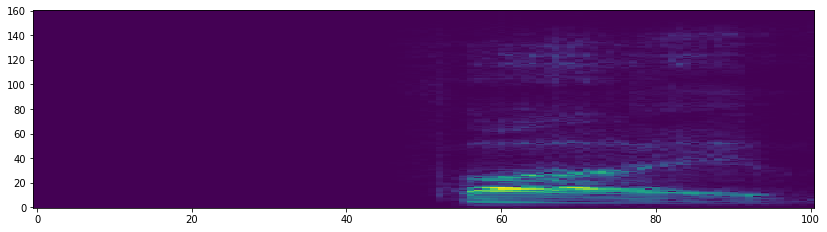

In [62]:
file="clip_cfc9a2de1.wav"
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.imshow(np.squeeze(get_spect(test_audio_path + file ), axis=0) , aspect='auto', origin='lower')
ipd.Audio(join(test_audio_path, file))